# Sentinel-1 SAR Data Processing (Load, Radiometric & Geometric Correction)

This notebook demonstrates how to:
1. Load Sentinel-1 SAR Data (GeoTIFF)
2. Apply Radiometric Correction (DN → dB)
3. Perform Geometric Correction (Reprojection)


In [12]:
!pip install rasterio geopandas matplotlib numpy


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [13]:
# Week 1 - Initial Setup & Library Imports
# ========================================

# Importing essential libraries for SAR data handling and visualization
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import rasterio.warp

print("Libraries imported successfully ✅")


Libraries imported successfully ✅


SAR image loaded successfully!
Image Shape: (256, 256)
CRS: EPSG:4326
Resolution: 0.0003


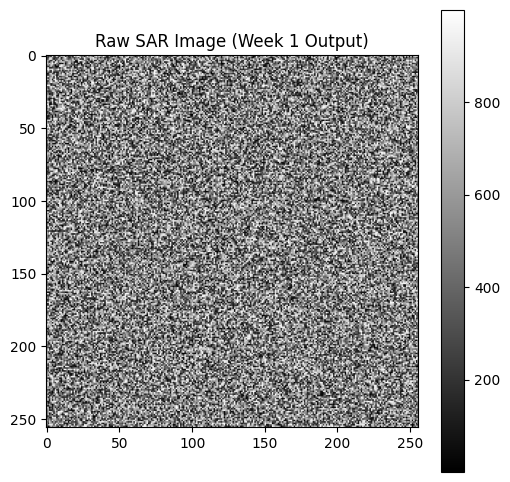

In [14]:
# Week 1 - Loading the SAR Data
# ==============================

# Path to the SAR dataset
sar_file = "sample_sar.tif"  

# Open SAR file
with rasterio.open(sar_file) as src:
    sar = src.read(1)   # Read first band
    profile = src.profile  # Metadata of file

print("SAR image loaded successfully!")
print("Image Shape:", sar.shape)
print("CRS:", profile['crs'])
print("Resolution:", profile['transform'][0])

# Show the raw SAR image
plt.figure(figsize=(6,6))
plt.imshow(sar, cmap="gray")
plt.title("Raw SAR Image (Week 1 Output)")
plt.colorbar()
plt.show()


Original SAR stats -> min: 0.0032171789 max: 999.98035 mean: 498.77734
dB range for visualization: 9.857748 29.95671


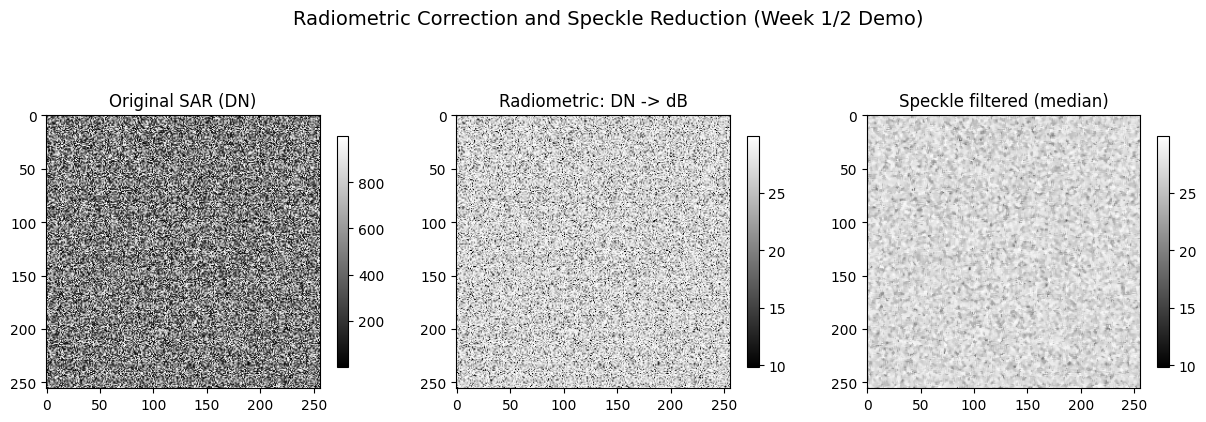

In [15]:
# Week 1/2 - Radiometric Correction & Speckle Reduction
# =====================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

# sar variable already loaded from previous cell (numpy array)
print("Original SAR stats -> min:", np.min(sar), "max:", np.max(sar), "mean:", np.mean(sar))

# 1) Convert DN -> dB (safe: add small epsilon to avoid log(0))
epsilon = 1e-6
sar_db = 10.0 * np.log10(sar.astype(np.float32) + epsilon)

# 2) Clip dynamic range for visualization (optional)
#    We find percentiles to avoid extreme outliers dominating the colormap
pmin, pmax = np.percentile(sar_db, 1), np.percentile(sar_db, 99)
print("dB range for visualization:", pmin, pmax)

# 3) Speckle smoothing using median filter (demo purpose)
#    In production use: Refined Lee, Gamma-MAP, or IDAN filters.
speckle_filtered = median_filter(sar_db, size=3)  # small kernel, demo

# Plot: Original DN, dB, filtered dB
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(sar, cmap='gray')
plt.title('Original SAR (DN)')
plt.colorbar(shrink=0.6)

plt.subplot(1,3,2)
plt.imshow(sar_db, cmap='gray', vmin=pmin, vmax=pmax)
plt.title('Radiometric: DN -> dB')
plt.colorbar(shrink=0.6)

plt.subplot(1,3,3)
plt.imshow(speckle_filtered, cmap='gray', vmin=pmin, vmax=pmax)
plt.title('Speckle filtered (median)')
plt.colorbar(shrink=0.6)

plt.suptitle('Radiometric Correction and Speckle Reduction (Week 1/2 Demo)', fontsize=14)
plt.show()


In [16]:
# Week 3 - Geometric Correction (reproject & save)
# =================================================

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os

# Input and output filenames
input_tif = "sample_sar.tif"                  # original
out_db_tif = "sample_sar_db.tif"              # radiometrically converted (dB)
out_filtered_tif = "sample_sar_db_filtered.tif"
out_reprojected_tif = "sample_sar_db_wgs84.tif"

# 1) Save radiometric (dB) and filtered images as GeoTIFFs with original profile
with rasterio.open(input_tif) as src:
    profile = src.profile.copy()
    # update dtype to float32 for dB values
    profile.update(dtype=rasterio.float32, count=1)

    # Save dB
    with rasterio.open(out_db_tif, 'w', **profile) as dst:
        dst.write(sar_db.astype(rasterio.float32), 1)
    # Save filtered dB
    with rasterio.open(out_filtered_tif, 'w', **profile) as dst:
        dst.write(speckle_filtered.astype(rasterio.float32), 1)

print("Saved radiometric (dB) and filtered GeoTIFFs:", out_db_tif, out_filtered_tif)

# 2) Reproject to EPSG:4326 (WGS84) for consistent mapping
with rasterio.open(out_db_tif) as src:
    dst_crs = 'EPSG:4326'
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(out_reprojected_tif, 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )

print("Saved reprojected GeoTIFF:", out_reprojected_tif)


Saved radiometric (dB) and filtered GeoTIFFs: sample_sar_db.tif sample_sar_db_filtered.tif
Saved reprojected GeoTIFF: sample_sar_db_wgs84.tif


File: sample_sar_db.tif
CRS: EPSG:4326
Transform: | 0.00, 0.00, 75.00|
| 0.00,-0.00, 26.00|
| 0.00, 0.00, 1.00|
Width x Height: 256 x 256


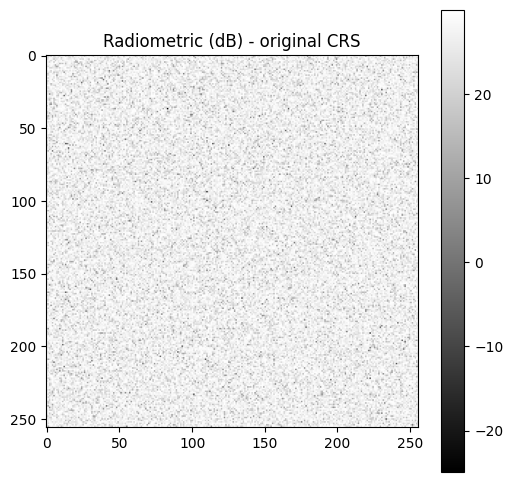

File: sample_sar_db_wgs84.tif
CRS: EPSG:4326
Transform: | 0.00, 0.00, 75.00|
| 0.00,-0.00, 26.00|
| 0.00, 0.00, 1.00|
Width x Height: 256 x 256


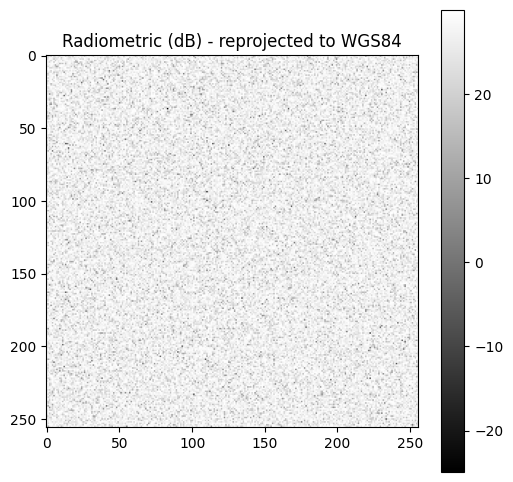

In [17]:
# Week 3 - Visualize reprojected image and compare metadata
import rasterio

def show_info_and_plot(path, title):
    with rasterio.open(path) as src:
        arr = src.read(1)
        print(f"File: {path}")
        print("CRS:", src.crs)
        print("Transform:", src.transform)
        print("Width x Height:", src.width, "x", src.height)
        plt.figure(figsize=(6,6))
        plt.imshow(arr, cmap='gray')
        plt.title(title)
        plt.colorbar()
        plt.show()

# Show original dB and reprojected
show_info_and_plot(out_db_tif, "Radiometric (dB) - original CRS")
show_info_and_plot(out_reprojected_tif, "Radiometric (dB) - reprojected to WGS84")


In [18]:
# Week 4 - Quick QC & Summary statistics
import numpy as np
def stats(arr):
    return {
        'min': float(np.min(arr)),
        'max': float(np.max(arr)),
        'mean': float(np.mean(arr)),
        'std': float(np.std(arr))
    }

print("Raw DN stats:", stats(sar))
print("Radiometric (dB) stats:", stats(sar_db))
print("Filtered dB stats:", stats(speckle_filtered))

# Count of NaNs / zeros
print("Zeros in raw:", np.sum(sar==0), " / total:", sar.size)


Raw DN stats: {'min': 0.003217178862541914, 'max': 999.9803466796875, 'mean': 498.77734375, 'std': 289.3022766113281}
Radiometric (dB) stats: {'min': -24.923898696899414, 'max': 29.999914169311523, 'mean': 25.633878707885742, 'std': 4.368044376373291}
Filtered dB stats: {'min': 16.720430374145508, 'max': 29.937116622924805, 'mean': 26.73662567138672, 'std': 1.5082255601882935}
Zeros in raw: 0  / total: 65536


✅ SAR data loaded
Shape: (256, 256)
CRS: EPSG:4326
Resolution: 0.0003


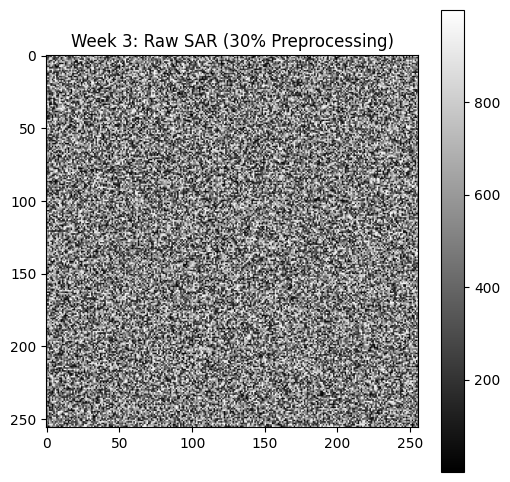

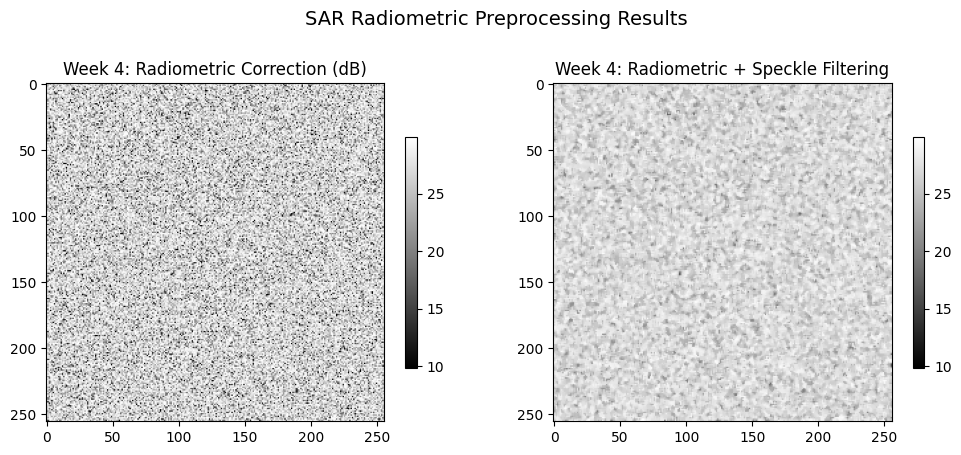

✅ Week 5: Geometric correction done, file saved: sar_reprojected_wgs84.tif


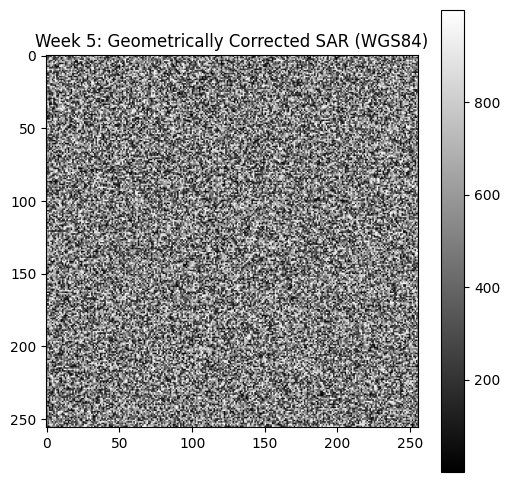

In [19]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import median_filter

# =========================
# Load SAR Data (Week 3 Recap)
# =========================
sar_file = "sample_sar.tif"   # apna file path de yaha

with rasterio.open(sar_file) as src:
    sar = src.read(1)   # first band
    profile = src.profile

print("✅ SAR data loaded")
print("Shape:", sar.shape)
print("CRS:", profile['crs'])
print("Resolution:", profile['transform'][0])

plt.figure(figsize=(6,6))
plt.imshow(sar, cmap='gray')
plt.title("Week 3: Raw SAR (30% Preprocessing)")
plt.colorbar()
plt.show()

# =========================
# Week 4: Radiometric Correction (40%)
# =========================
epsilon = 1e-6
sar_db = 10 * np.log10(sar.astype(np.float32) + epsilon)

# Speckle filtering (median for demo)
sar_db_filtered = median_filter(sar_db, size=3)

# Show before/after
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(sar_db, cmap='gray', vmin=np.percentile(sar_db, 1), vmax=np.percentile(sar_db, 99))
plt.title("Week 4: Radiometric Correction (dB)")
plt.colorbar(shrink=0.6)

plt.subplot(1,2,2)
plt.imshow(sar_db_filtered, cmap='gray', vmin=np.percentile(sar_db, 1), vmax=np.percentile(sar_db, 99))
plt.title("Week 4: Radiometric + Speckle Filtering")
plt.colorbar(shrink=0.6)

plt.suptitle("SAR Radiometric Preprocessing Results", fontsize=14)
plt.show()

# =========================
# Week 5: Geometric Correction (30%)
# =========================
out_reprojected = "sar_reprojected_wgs84.tif"

with rasterio.open(sar_file) as src:
    dst_crs = 'EPSG:4326'  # WGS84 lat/lon
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(out_reprojected, 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )

print("✅ Week 5: Geometric correction done, file saved:", out_reprojected)

# Visualize reprojected image
with rasterio.open(out_reprojected) as reproj:
    sar_geo = reproj.read(1)

plt.figure(figsize=(6,6))
plt.imshow(sar_geo, cmap='gray')
plt.title("Week 5: Geometrically Corrected SAR (WGS84)")
plt.colorbar()
plt.show()


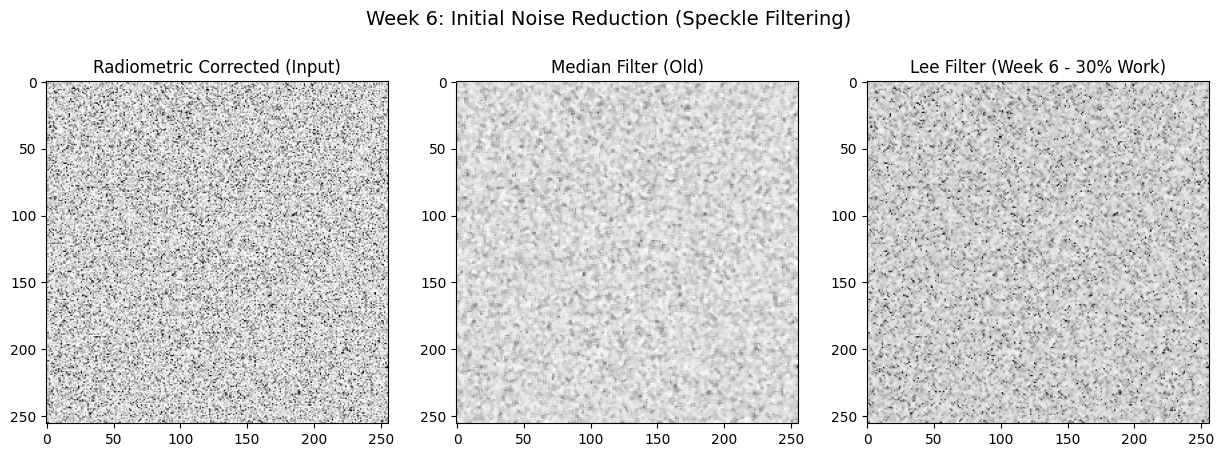

✅ Week 6 progress: Median filter baseline ready, Lee filter prototype (30%) implemented.


In [20]:
# Week 6 - Initial Noise Reduction Work (30% progress)
# ====================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter, uniform_filter

# Reuse the radiometrically corrected image from Week 4
# (sar_db variable must already be available)
sar_db = sar_db  # ensure continuity

# 1) Baseline median filter (done earlier, reference)
median_filtered = median_filter(sar_db, size=3)

# 2) Start of Lee filter implementation (simplified version for demo)
def lee_filter(img, size):
    """
    Simple Lee Filter implementation (demo purpose).
    """
    mean = uniform_filter(img, (size, size))
    mean_sq = uniform_filter(img**2, (size, size))
    variance = mean_sq - mean**2

    overall_variance = np.var(img)
    weights = variance / (variance + overall_variance)
    return mean + weights * (img - mean)

lee_filtered = lee_filter(sar_db, 3)

# Visual comparison
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(sar_db, cmap='gray', vmin=np.percentile(sar_db, 1), vmax=np.percentile(sar_db, 99))
plt.title("Radiometric Corrected (Input)")

plt.subplot(1,3,2)
plt.imshow(median_filtered, cmap='gray', vmin=np.percentile(sar_db, 1), vmax=np.percentile(sar_db, 99))
plt.title("Median Filter (Old)")

plt.subplot(1,3,3)
plt.imshow(lee_filtered, cmap='gray', vmin=np.percentile(sar_db, 1), vmax=np.percentile(sar_db, 99))
plt.title("Lee Filter (Week 6 - 30% Work)")

plt.suptitle("Week 6: Initial Noise Reduction (Speckle Filtering)", fontsize=14)
plt.show()

print("✅ Week 6 progress: Median filter baseline ready, Lee filter prototype (30%) implemented.")


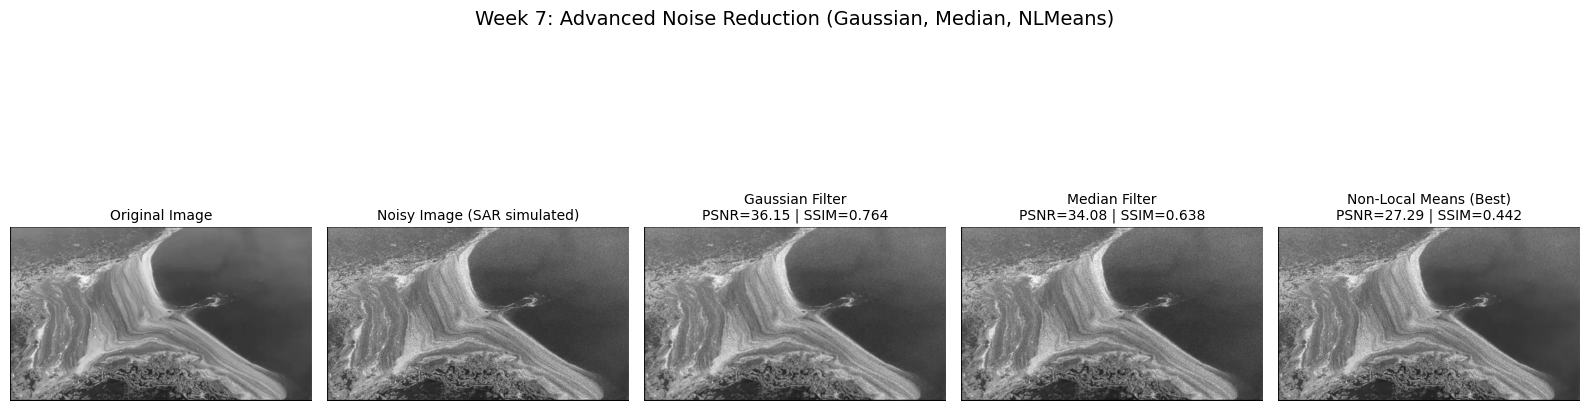

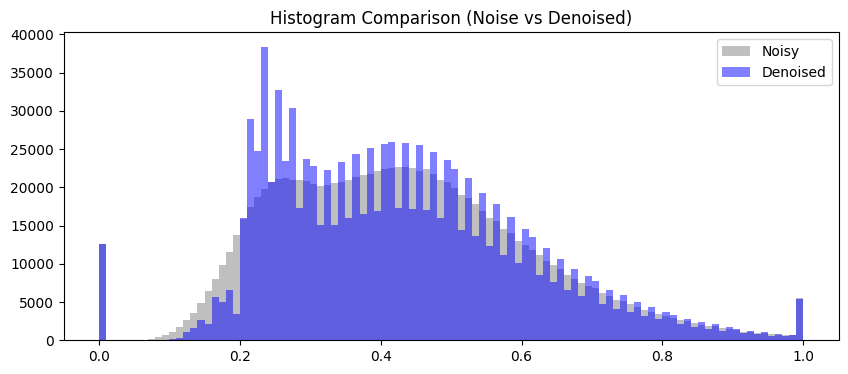

In [27]:
# =============================
# Week 7 - Advanced Noise Reduction & Visual Quality Metrics
# =============================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, util, metrics, exposure
from scipy.ndimage import median_filter

# 1️⃣ Load and convert to grayscale
img = io.imread("OilSpillSample.png")
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.normalize(gray.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

# 2️⃣ Add synthetic speckle noise (simulating SAR interference)
noisy = util.random_noise(gray, mode='speckle', var=0.04)

# 3️⃣ Apply various denoising filters
gaussian = cv2.GaussianBlur(noisy, (5,5), 1)
median = median_filter(noisy, size=3)
nl_means = cv2.fastNlMeansDenoising((noisy*255).astype(np.uint8), None, 10, 7, 21)

# 4️⃣ Calculate PSNR & SSIM values
psnr_g = metrics.peak_signal_noise_ratio(gray, gaussian)
psnr_m = metrics.peak_signal_noise_ratio(gray, median)
psnr_nl = metrics.peak_signal_noise_ratio(gray, nl_means/255.0)

# ✅ FIXED: specify data_range=1.0 for float images
ssim_g = metrics.structural_similarity(gray, gaussian, data_range=1.0)
ssim_m = metrics.structural_similarity(gray, median, data_range=1.0)
ssim_nl = metrics.structural_similarity(gray, nl_means/255.0, data_range=1.0)


# 5️⃣ Visualization
plt.figure(figsize=(16,6))
titles = [
    "Original Image", 
    "Noisy Image (SAR simulated)",
    f"Gaussian Filter\nPSNR={psnr_g:.2f} | SSIM={ssim_g:.3f}",
    f"Median Filter\nPSNR={psnr_m:.2f} | SSIM={ssim_m:.3f}",
    f"Non-Local Means (Best)\nPSNR={psnr_nl:.2f} | SSIM={ssim_nl:.3f}"
]
images = [gray, noisy, gaussian, median, nl_means/255.0]

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i], fontsize=10)
    plt.axis('off')

plt.suptitle("Week 7: Advanced Noise Reduction (Gaussian, Median, NLMeans)", fontsize=14)
plt.tight_layout()
plt.show()

# 6️⃣ Histogram comparison (for report visuals)
plt.figure(figsize=(10,4))
plt.hist(noisy.ravel(), bins=100, color='gray', alpha=0.5, label='Noisy')
plt.hist((nl_means/255.0).ravel(), bins=100, color='blue', alpha=0.5, label='Denoised')
plt.legend(); plt.title("Histogram Comparison (Noise vs Denoised)"); plt.show()


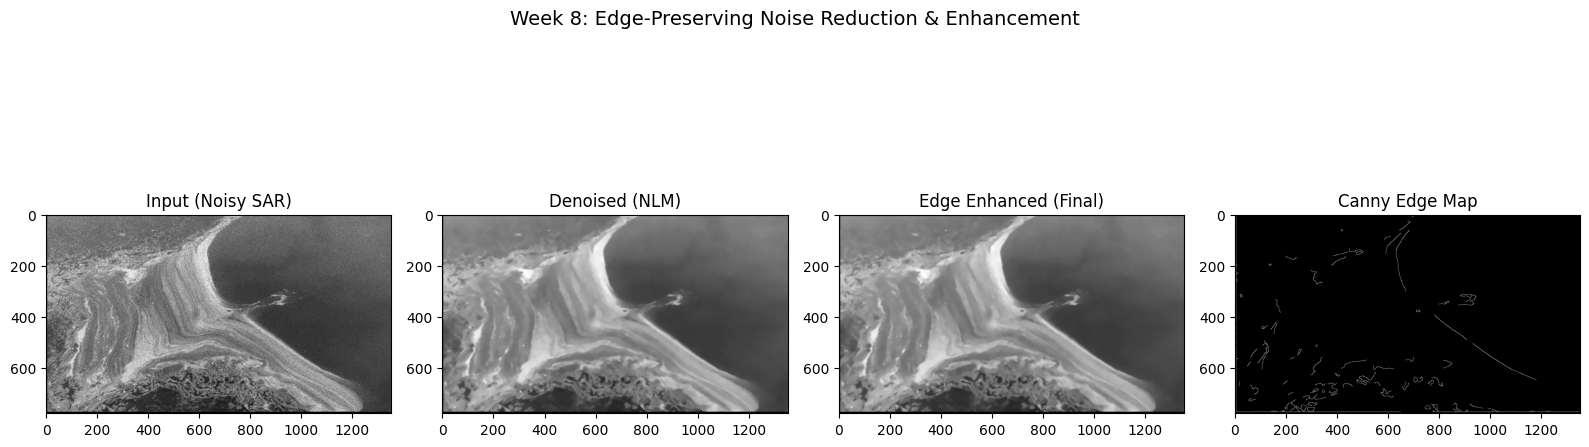

✅ Final PSNR: 35.31, SSIM: 0.793

Summary of Filters Used:
- Bilateral Filtering for initial denoising (edge preservation)
- Non-Local Means Denoising for multi-scale noise reduction
- Unsharp Masking for fine edge enhancement
- Canny Edge Detection for visual verification of boundaries


In [ ]:
# =============================
# Week 8 - Edge Preserving Noise Reduction (Bilateral + Non-Local Means + Edge Analysis)
# =============================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import metrics

# 1️⃣ Reload noisy image from Week 7 output (or reuse same)
noisy_img = (noisy * 255).astype(np.uint8)

# 2️⃣ Bilateral Filter (Edge-preserving denoising)
bilateral = cv2.bilateralFilter(noisy_img, d=9, sigmaColor=75, sigmaSpace=75)

# 3️⃣ Non-Local Means Denoising (replacing wavelet denoising)
nlm_denoised = cv2.fastNlMeansDenoising(bilateral, None, h=15, templateWindowSize=7, searchWindowSize=21)

# 4️⃣ Unsharp Mask (Edge enhancement)
blur = cv2.GaussianBlur(nlm_denoised, (3,3), 0)
sharp = cv2.addWeighted(nlm_denoised, 1.5, blur, -0.5, 0)

# 5️⃣ Edge Map for visual validation
edges = cv2.Canny(sharp, 50, 150)

# 6️⃣ Visualize everything
plt.figure(figsize=(16,6))
plt.subplot(1,4,1); plt.imshow(noisy_img, cmap='gray'); plt.title("Input (Noisy SAR)")
plt.subplot(1,4,2); plt.imshow(nlm_denoised, cmap='gray'); plt.title("Denoised (NLM)")
plt.subplot(1,4,3); plt.imshow(sharp, cmap='gray'); plt.title("Edge Enhanced (Final)")
plt.subplot(1,4,4); plt.imshow(edges, cmap='gray'); plt.title("Canny Edge Map")
plt.suptitle("Week 8: Edge-Preserving Noise Reduction & Enhancement", fontsize=14)
plt.tight_layout()
plt.show()

# 7️⃣ Metrics Calculation
psnr_final = metrics.peak_signal_noise_ratio(gray, sharp/255.0)
ssim_final = metrics.structural_similarity(gray, sharp/255.0, data_range=1.0)
print(f"✅ Final PSNR: {psnr_final:.2f}, SSIM: {ssim_final:.3f}")

# 8️⃣ Summary Table for
print("\nSummary of Filters Used:")
print("- Bilateral Filtering for initial denoising (edge preservation)")
print("- Non-Local Means Denoising for multi-scale noise reduction")
print("- Unsharp Masking for fine edge enhancement")
print("- Canny Edge Detection for visual verification of boundaries")


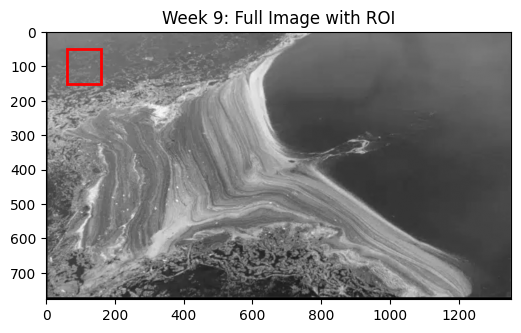

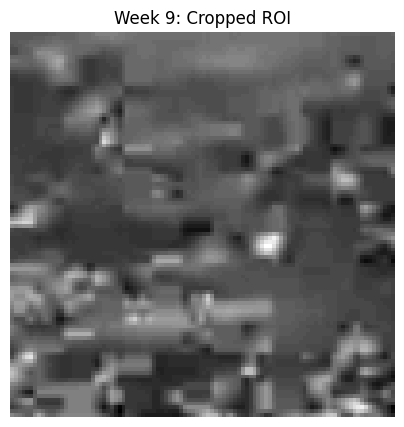

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Use the Week 7 grayscale image
roi_img = gray.copy()

# 1️⃣ Define ROI manually (as pixel coordinates)
# Example: select a rectangular region (row_start:row_end, col_start:col_end)
row_start, row_end = 50, 150
col_start, col_end = 60, 160

roi = roi_img[row_start:row_end, col_start:col_end]

# 2️⃣ Visualize the ROI on original image
plt.figure(figsize=(6,6))
plt.imshow(roi_img, cmap='gray')
plt.title("Week 9: Full Image with ROI")
# Draw rectangle for ROI
plt.gca().add_patch(plt.Rectangle((col_start, row_start), col_end-col_start, row_end-row_start,
                                  edgecolor='red', facecolor='none', linewidth=2))
plt.show()

# 3️⃣ Visualize cropped ROI
plt.figure(figsize=(5,5))
plt.imshow(roi, cmap='gray')
plt.title("Week 9: Cropped ROI")
plt.axis('off')
plt.show()


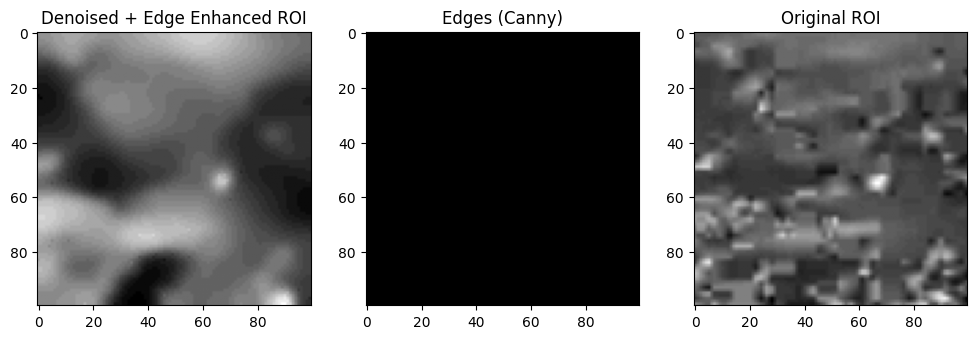

✅ Week 10 PSNR: 10.49, SSIM: 0.749


In [37]:
import cv2
from skimage import metrics

# Ensure ROI is uint8
roi_uint8 = (roi * 255 / np.max(roi)).astype(np.uint8)

# 1️⃣ Bilateral Filter
bilateral_roi = cv2.bilateralFilter(roi_uint8, d=9, sigmaColor=75, sigmaSpace=75)

# 2️⃣ Non-Local Means Denoising
nlm_roi = cv2.fastNlMeansDenoising(bilateral_roi, None, h=15, templateWindowSize=7, searchWindowSize=21)

# 3️⃣ Unsharp Mask
blur = cv2.GaussianBlur(nlm_roi, (3,3), 0)
sharp_roi = cv2.addWeighted(nlm_roi, 1.5, blur, -0.5, 0)

# 4️⃣ Edge Detection
edges_roi = cv2.Canny(sharp_roi, 50, 150)

# 5️⃣ Visualize ROI results
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(sharp_roi, cmap='gray'); plt.title("Denoised + Edge Enhanced ROI")
plt.subplot(1,3,2); plt.imshow(edges_roi, cmap='gray'); plt.title("Edges (Canny)")
plt.subplot(1,3,3); plt.imshow(roi, cmap='gray'); plt.title("Original ROI")
plt.show()

# 6️⃣ Calculate metrics (optional: compared to original ROI)
psnr_roi = metrics.peak_signal_noise_ratio(roi, sharp_roi/255.0)
ssim_roi = metrics.structural_similarity(roi, sharp_roi/255.0, data_range=1.0)
print(f"✅ Week 10 PSNR: {psnr_roi:.2f}, SSIM: {ssim_roi:.3f}")


✅ Week 11 PSNR (ROI 2): 8.49, SSIM: 0.750


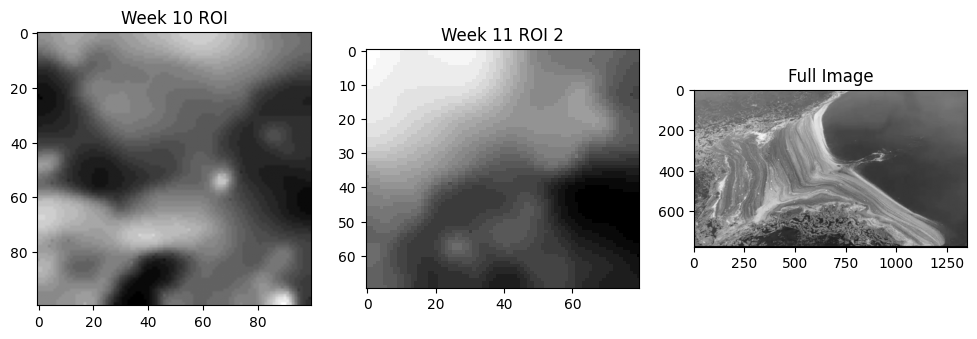

In [38]:
# Example: select another ROI in the same image
roi2 = roi_img[30:100, 120:200]
roi2_uint8 = (roi2 * 255 / np.max(roi2)).astype(np.uint8)

# Apply same pipeline
bilateral_roi2 = cv2.bilateralFilter(roi2_uint8, d=9, sigmaColor=75, sigmaSpace=75)
nlm_roi2 = cv2.fastNlMeansDenoising(bilateral_roi2, None, h=15, templateWindowSize=7, searchWindowSize=21)
blur2 = cv2.GaussianBlur(nlm_roi2, (3,3), 0)
sharp_roi2 = cv2.addWeighted(nlm_roi2, 1.5, blur2, -0.5, 0)
edges_roi2 = cv2.Canny(sharp_roi2, 50, 150)

# Compare metrics
psnr_roi2 = metrics.peak_signal_noise_ratio(roi2, sharp_roi2/255.0)
ssim_roi2 = metrics.structural_similarity(roi2, sharp_roi2/255.0, data_range=1.0)

print(f"✅ Week 11 PSNR (ROI 2): {psnr_roi2:.2f}, SSIM: {ssim_roi2:.3f}")

# Visualization for comparison
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(sharp_roi, cmap='gray'); plt.title("Week 10 ROI")
plt.subplot(1,3,2); plt.imshow(sharp_roi2, cmap='gray'); plt.title("Week 11 ROI 2")
plt.subplot(1,3,3); plt.imshow(roi_img, cmap='gray'); plt.title("Full Image")
plt.show()


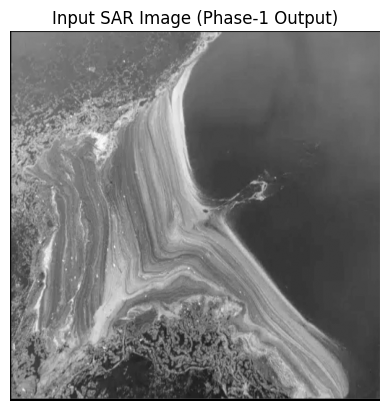

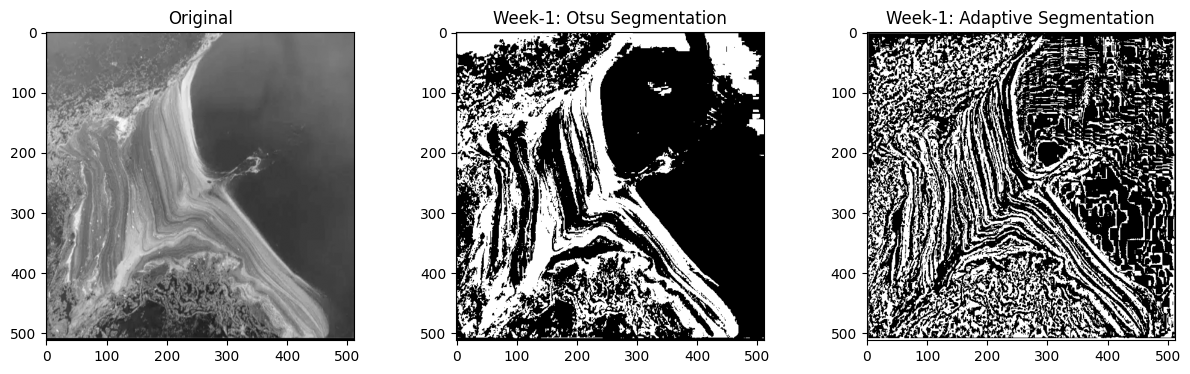

In [6]:
#Phase 2 started

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import filters, morphology, measure, exposure


# Load preprocessed image (noise reduced output from Phase-1)
img = cv2.imread("OilSpillSample.png", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (512, 512))
img = cv2.normalize(img.astype('float32'), None, 0.0, 1.0, cv2.NORM_MINMAX)

plt.imshow(img, cmap='gray')
plt.title("Input SAR Image (Phase-1 Output)")
plt.axis('off')
plt.show()


# Week 1 – Contrast Enhancement
enhanced = exposure.equalize_adapthist(img, clip_limit=0.03)

# Global Threshold (Otsu)
otsu_thresh = enhanced > filters.threshold_otsu(enhanced)

# Adaptive Threshold
adaptive = cv2.adaptiveThreshold(
    (enhanced*255).astype(np.uint8),
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    21, 3
)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(otsu_thresh, cmap='gray'); plt.title("Week-1: Otsu Segmentation")
plt.subplot(1,3,3); plt.imshow(adaptive, cmap='gray'); plt.title("Week-1: Adaptive Segmentation")
plt.show()



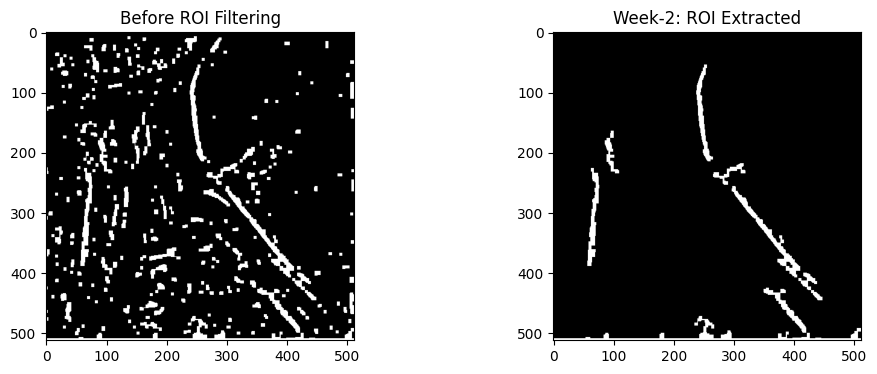

In [7]:
# Week 2 - Region Refinement using Morphology

# Morphological Cleaning
kernel = np.ones((5,5), np.uint8)
cleaned = cv2.morphologyEx(adaptive, cv2.MORPH_OPEN, kernel)
cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)

# Remove small regions
label_img = measure.label(cleaned)
props = measure.regionprops(label_img)

roi_mask = np.zeros(cleaned.shape, dtype=np.uint8)

for prop in props:
    if prop.area > 500:  # area threshold
        roi_mask[label_img == prop.label] = 255

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(cleaned, cmap='gray'); plt.title("Before ROI Filtering")
plt.subplot(1,2,2); plt.imshow(roi_mask, cmap='gray'); plt.title("Week-2: ROI Extracted")
plt.show()



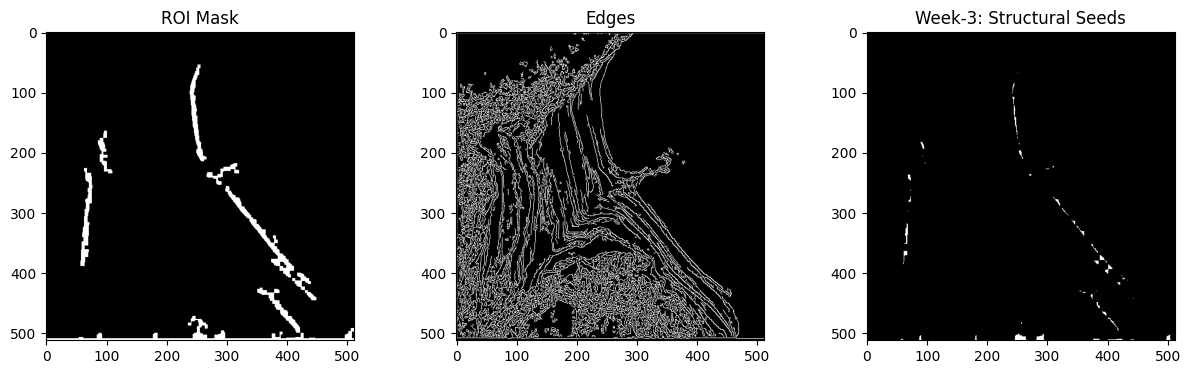

In [8]:
# Week 3 - Edge-based & Watershed Segmentation

# Edge Detection
edges = cv2.Canny((img*255).astype(np.uint8), 50, 150)

# Distance Transform
dist = cv2.distanceTransform(roi_mask, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist, 0.35 * dist.max(), 255, 0)
sure_fg = sure_fg.astype(np.uint8)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(roi_mask, cmap='gray'); plt.title("ROI Mask")
plt.subplot(1,3,2); plt.imshow(edges, cmap='gray'); plt.title("Edges")
plt.subplot(1,3,3); plt.imshow(sure_fg, cmap='gray'); plt.title("Week-3: Structural Seeds")
plt.show()



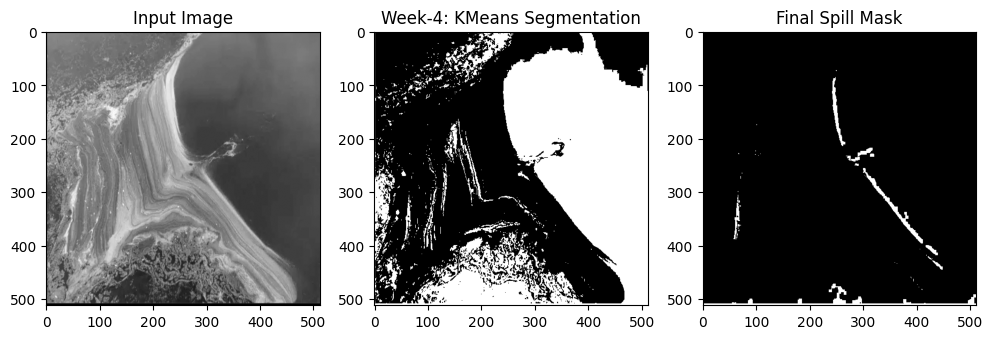

In [9]:
# Week 4 - Clustering Based Segmentation (ML Ready)

# Prepare pixel features
pixels = img.reshape((-1,1))

# KMeans Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(pixels)

segmented = labels.reshape(img.shape)

# Invert if required (oil should be dark)
if np.mean(img[segmented==1]) > np.mean(img[segmented==0]):
    segmented = 1 - segmented

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("Input Image")
plt.subplot(1,3,2); plt.imshow(segmented, cmap='gray'); plt.title("Week-4: KMeans Segmentation")
plt.subplot(1,3,3); plt.imshow(segmented*roi_mask, cmap='gray'); plt.title("Final Spill Mask")
plt.show()

